# Prequisites

In [129]:
import os
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")

from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader
import torch
import time
from tqdm.notebook import tqdm
from tempfile import TemporaryDirectory
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter # For tensorboard support
from copy import deepcopy

## Dataset Creation

In [11]:
main_dir = "raw-img"
dic = {}

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    count = len(os.listdir(img_folder))
    dic[i] = count

<BarContainer object of 10 artists>

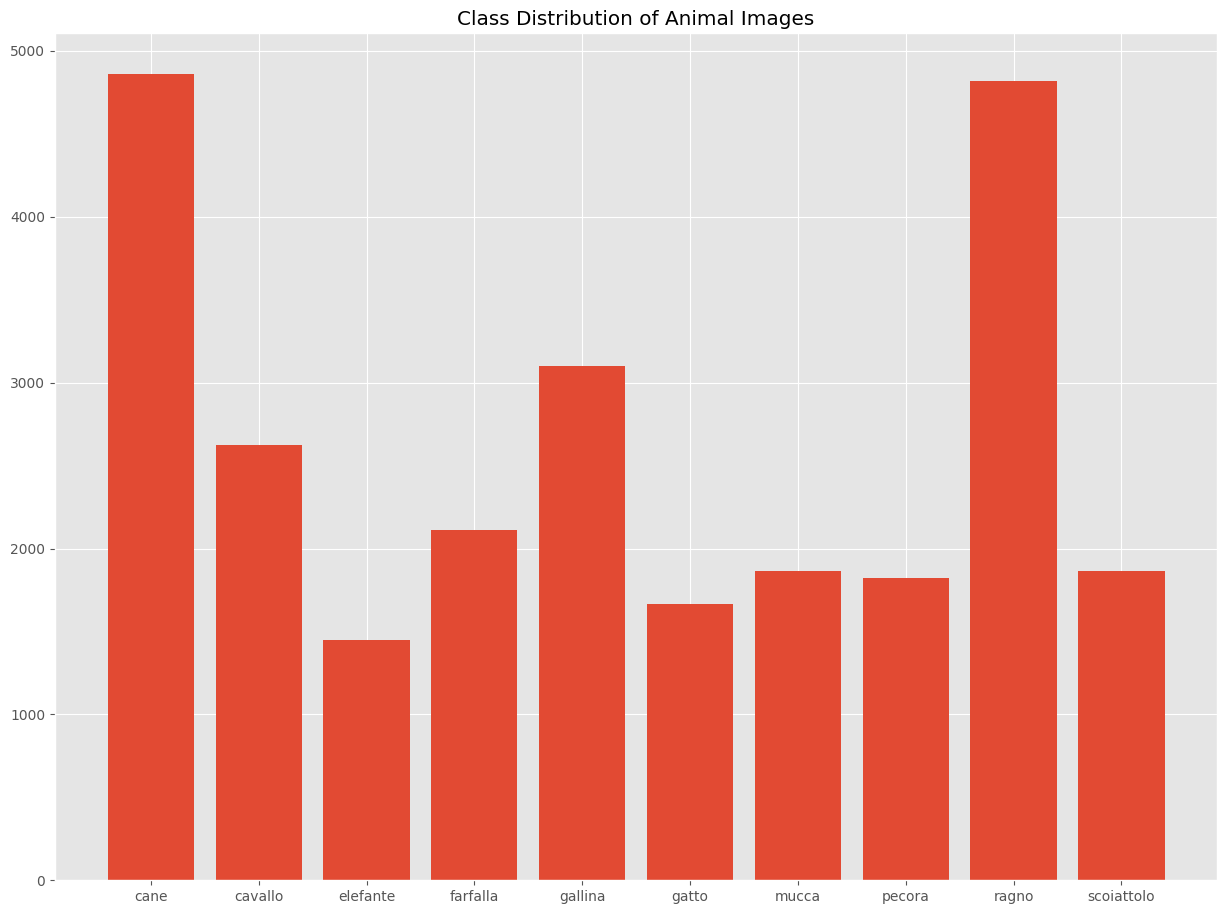

In [12]:
x = list(dic.keys())
y = list(dic.values())
plt.figure(figsize=(15, 11)) #Width , height
plt.title("Class Distribution of Animal Images")
plt.bar(x, y)

In [13]:
#Creating encoded labels for the animals 

animal_key = {}
count = 0 
main_dir = "raw-img"

for i in os.listdir(main_dir):
    animal_key[i] = count
    count += 1 
animal_key

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

In [14]:
#Creating a csv with image paths before using our custom data loader

main_dir = "raw-img" 
train_img_paths = []
train_labels = []
test_img_paths = []
test_labels = []

counter = 0

for i in os.listdir(main_dir):
    img_folder = os.path.join(main_dir, i)
    for j in os.listdir(img_folder):
        img_path = os.path.join(img_folder, j)
        if(counter % 6 == 0):
            test_img_paths.append(img_path)
            test_labels.append(animal_key[i])
        else:
            train_img_paths.append(img_path)
            train_labels.append(animal_key[i]) 
        counter += 1

data = pd.DataFrame([train_img_paths, train_labels])
data = data.transpose()
data.to_csv("train.csv", index=None)
print("Training Images are ",len(train_img_paths))

data = pd.DataFrame([test_img_paths, test_labels])
data = data.transpose()
data.to_csv("test.csv", index=None)
print("Testing Images are ",len(test_img_paths))



Training Images are  21815
Testing Images are  4364


In [15]:
class CustomDatasetLoader(Dataset):
    def __init__(self, csv_path, transform=None): #Init function runs only once when instantiating the Dataset object
        self.img_info = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self): #Returns the total number of data points
        return len(self.img_info)

    def __getitem__(self, index): #Should return the image and label from the data source as per the "index" value iterated over the length
        img_path = self.img_info.iloc[index, 0]
        img = read_image(img_path, mode=ImageReadMode.RGB)
        label = self.img_info.iloc[index, 1]
        if self.transform:
            img = self.transform(img)
        return img, label 

In [16]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((128, 128)),  
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
#The values for normalization and standardization are given as per the recommended values from https://pytorch.org/vision/0.9/models.html

In [17]:
train_data = CustomDatasetLoader("train.csv", train_transform)
test_data = CustomDatasetLoader("test.csv", test_transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=128)
test_loader = DataLoader(test_data, shuffle=True, batch_size=128)

# Basic Transfer Learning

Fixed Feature Extractor

All the layers are frozen except for the last classification layer/s which is also modified as the number of classes prediction has to be same as our use case

In [87]:
model = torchvision.models.vgg16(pretrained=True) 

c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
for parameter in model.parameters():
    parameter.requires_grad = False #the .requires_grad=True by default for all layers
 
model.classifier[-1] = torch.nn.Linear(4096, 10)

for i in model.classifier.parameters():
    i.requires_grad = True 

In [89]:
#Defining device 

if torch.cuda.is_available():
    print("GPU Available")
    device = torch.device("cuda")
else:
    print("Device is CPU")
    device = torch.device("cpu")

model = model.to(device)

GPU Available


In [90]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#Decay LR by a factor of 0.1 every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [91]:
#timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter("runs/classifier_{}".format(timestamp))


training_accuracy_list = []
training_loss_list = []
length = []

def model_training(total_epochs, optimizer, criterion, model, device):
    counter= 0
    for epoch in range(total_epochs):
        print(f"Epoch :{epoch}")

        #Make model trainable | Gradien tracking is on 
        model.train()
        #One pass over data
        running_loss = 0.
        running_accuracy = 0.
        total_samples = 0.

        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad() #Zero the gradients for every batch
            outputs = model(inputs) #Predictions for this batch
            loss = criterion(outputs, targets) #Computer loss and its gradients
            loss.backward()
            optimizer.step() #Adjust learning weights 
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Assuming classification
            running_accuracy += torch.sum(preds == targets).item()
            total_samples += inputs.size(0)

        training_accuracy_result = running_accuracy / total_samples
        training_accuracy_list.append(training_accuracy_result)
        loss_result = float(running_loss / total_samples)
        training_loss_list.append(loss_result)
        length.append(counter)
        counter += 1
        print(f"For Batch size {len(train_loader)} images\nLoss ={loss_result}") 
        print(f"Training Accuracy : {training_accuracy_result}")
    return model 


In [92]:
a = time.time()
model = model_training(7, optimizer, criterion, model, device)
print("Total training time is {} seconds".format(time.time()-a))

Epoch :0


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.003257538325983861
Training Accuracy : 0.8674765069906027
Epoch :1


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0019890500018691186
Training Accuracy : 0.9170754068301628
Epoch :2


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0017207247615133763
Training Accuracy : 0.9297730919092367
Epoch :3


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0015505658922434782
Training Accuracy : 0.9349530139812056
Epoch :4


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0014306698077292774
Training Accuracy : 0.9407288562915426
Epoch :5


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.001315688903851436
Training Accuracy : 0.9443043777217511
Epoch :6


  0%|          | 0/171 [00:00<?, ?it/s]

For Batch size 171 images
Loss =0.0012619980489021864
Training Accuracy : 0.9482924593169837
Total training time is 506.99375677108765 seconds


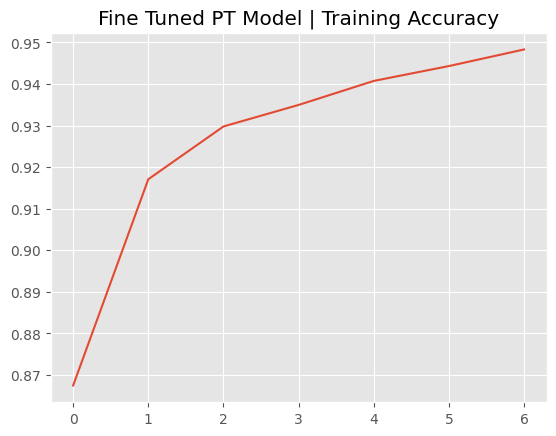

In [93]:
plt.title("Fine Tuned PT Model | Training Accuracy")
plt.plot(length, training_accuracy_list)

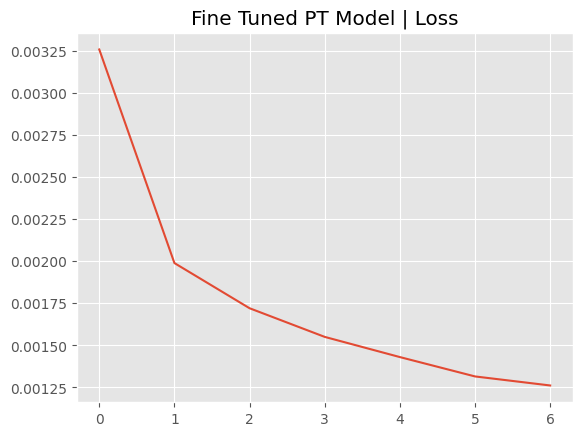

In [94]:
plt.title("Fine Tuned PT Model | Loss")
plt.plot(length, training_loss_list)

In [95]:
torch.save(model, "finetuned.pth") #Saveing with structure of class together with the model
torch.save(model.state_dict(), "finetuned_state_dict.pth")

In [55]:
with open("results/finetune.txt", "w") as file:
    file.write("Training Accuracy" +"\t" + "Loss Values" + "\n")
    for index, i in enumerate(length):
        file.write(str(training_accuracy_list[index]) + "\t" + str(training_loss_list[index]) + "\n")

In [56]:
#Count total number of parameters in PyTorch Model
sum = 0
for layer in model.parameters():
    sum += layer.numel()

print("Total number of parameters are ", sum)

Total number of parameters are  134301514


In [57]:
#Inferencing 

img_path = "raw-img\scoiattolo\OIP-zzy5kEbHuGBWXZ3c-D85aAHaE8.jpeg"
img = read_image(img_path, mode=ImageReadMode.RGB)
img = torchvision.transforms.Resize((128, 128))(img)
img = img.unsqueeze(0)
img = img.to(device).float()
print("shape of image is ", img.shape)

model.eval()
model = model.to(device)
with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

#preds[0].cpu().item()
preds

shape of image is  torch.Size([1, 3, 128, 128])


tensor([8], device='cuda:0')

Note :- I see that PyTorch can take dynamic shapes as inputs but the accuracy differs a lot which does make sense i guess.

In [58]:
model = torch.load("finetuned.pth")

In [59]:
#GPU Inference Comparison

batch_sizes = [1, 8, 32, 64, 128, 256]
ts = []
device = torch.device("cuda")

with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).to(device).float()
        a = time.time()
        outputs = model(x)
        ts.append(time.time()-a)

torch.cuda.empty_cache()

ts

[0.0019981861114501953,
 0.03299975395202637,
 0.03200554847717285,
 0.025999069213867188,
 0.002002716064453125,
 2.325514793395996]

In [60]:
#CPU Inference Comparison

batch_sizes = [1, 8, 32, 64, 128, 256]
ts = []
device = torch.device("cpu")
model.eval().to(device)

with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).to(device).float()
        a = time.time()
        outputs = model(x)
        ts.append(time.time()-a)

ts

[0.1133718490600586,
 0.31255316734313965,
 1.0323724746704102,
 2.4080650806427,
 4.245094060897827,
 7.154498815536499]

In [61]:
#Evaluation 

device = torch.device("cpu")
model.eval().to(device)
correct, total = 0., 0.
with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = model(data)
        _, predictions = torch.max(output, 1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
print(correct / total)

  0%|          | 0/35 [00:00<?, ?it/s]

0.9424839596700275


# Dynamic Quantization

In [62]:
model = torch.load("finetuned.pth")

In [63]:
import torch.quantization as quant

model.eval().to(device="cpu")

quantized_model = quant.quantize_dynamic(model, 
                                         {torch.nn.Linear}, 
                                         dtype=torch.qint8)

In [64]:
torch.save(quantized_model, "int8_dynamic_quantization.pth")
#From 512MB to 172MB
#Had Seen 0.3% reduction for Googlenet
#Had seen 30% reduction for MobileNetV3, but then again is it the architecture or the small size?

In [66]:
device = torch.device("cpu")
quantized_model = torch.load("int8_dynamic_quantization.pth").to(device)
quantized_model.eval()

batch_sizes = [1, 8, 32, 64, 128, 256]
ts = []


with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).float()
        a = time.time()
        outputs = quantized_model(x)
        ts.append(time.time()-a)

ts

[0.03606772422790527,
 0.22102117538452148,
 0.8117117881774902,
 1.6755945682525635,
 3.511547565460205,
 7.186212539672852]

I tried to run on GPU but for X86 system and the current version of the library the support for these opearators are not there for Int8

In [67]:
#Tensor comparison 

data, targets = next(iter(train_loader))

data = data.to(device="cpu")

original_output = model(data)
quantized_output = quantized_model(data)
comparison = torch.allclose(original_output, quantized_output, atol=1e-1)
comparison

False

In [68]:
device = torch.device("cpu")
quantized_model.eval().to(device)
correct, total = 0., 0.
with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = quantized_model(data)
        _, predictions = torch.max(output, 1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
print(correct / total)

  0%|          | 0/35 [00:00<?, ?it/s]

0.9424839596700275


# Static Quantization 

## Eager Mode Quantization | With Calibration

In [2]:
from torch.ao.quantization import(
    get_default_qconfig_mapping,
    get_default_qat_qconfig_mapping,
    QConfigMapping
)
import torch.ao.quantization.quantize_fx as quantize_fx 
import copy

In [3]:
model = torch.load("finetuned.pth").to("cpu")
model_to_quantize = copy.deepcopy(model)

In [4]:
model_to_quantize.eval()
#qconfig_mapping = QConfigMapping().set_global(torch.ao.quantization.default_dynamic_qconfig)
qconfig_mapping = get_default_qat_qconfig_mapping("x86")

In [13]:
inputs, target = next(iter(train_loader))
single_input_example = inputs[0].unsqueeze(0)
#Taking single image to prepare for tracing the model
prepared_model = quantize_fx.prepare_fx(model_to_quantize,
                                        qconfig_mapping,
                                        single_input_example)

model_to_quantize = quantize_fx.convert_fx(prepared_model) 

c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torch\ao\quantization\observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torch\ao\quantization\utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


"fbgemm" and "qnnpack" for x86 and ARM Machines respectively as per the old documentation but some docs are showing we can use "x86" or "onednn"

In [14]:
quantized_fused_model = quantize_fx.fuse_fx(model_to_quantize)

In [15]:
a, b = torch.max(quantized_fused_model(single_input_example), 1)
b

tensor([3])

In [16]:
b.dtype

torch.int64

In [30]:
#Saving and loading the quantized models

quantized_fused_model.eval()
scripted_model = torch.jit.script(quantized_fused_model)
torch.jit.save(scripted_model, "Quantized_Fused_Model")

quantized_model = torch.jit.load("Quantized_Fused_Model")

c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torch\jit\_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [33]:
device = torch.device("cpu")
quantized_model.to(device).eval()

batch_sizes = [1, 8, 32, 64, 128, 256]
ts = []


with torch.no_grad():
    for size in batch_sizes:
        x = torch.rand(size, 3, 128, 128).float()
        a = time.time()
        outputs = quantized_model(x)
        ts.append(time.time()-a)
ts


[0.018521547317504883,
 0.11658930778503418,
 0.3476994037628174,
 0.7263298034667969,
 1.37361741065979,
 2.690702199935913]

In [34]:
device = torch.device("cpu")
quantized_model.to(device).eval()
correct, total = 0., 0.
with torch.no_grad():
    for data, target in tqdm(test_loader):
        output = quantized_model(data)
        _, predictions = torch.max(output, 1)
        total += target.size(0)
        correct += (predictions == target).sum().item()
print(correct / total)

  0%|          | 0/35 [00:00<?, ?it/s]

0.22891842346471128


## Quantization Aware Training (QAT)

In [138]:
model = torchvision.models.vgg16(pretrained=True) 

for parameter in model.parameters():
    parameter.requires_grad = False #the .requires_grad=True by default for all layers
 
model.classifier[-1] = torch.nn.Linear(4096, 10)

for i in model.classifier.parameters():
    i.requires_grad = True

qt_model = deepcopy(model)
qt_model.to("cuda").train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [139]:
quantization_config = torch.quantization.get_default_qconfig("x86")

#qt_model = float_model
qt_model.qconfig = quantization_config



torch.quantization.prepare_qat(qt_model, inplace=True)
#we can also use torch.quantization.prepare_qat(qt_model, inplace=True)

c:\Users\prish\miniconda3\envs\temp\Lib\site-packages\torch\ao\quantization\observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


VGG(
  (features): Sequential(
    (0): Conv2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([], device='cuda:0'), max_val=tensor([], device='cuda:0'))
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (1): ReLU(inplace=True)
    (2): Conv2d(
      64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([], device='cuda:0'), max_val=tensor([], device='cuda:0'))
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(
      64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([], device='cuda:0'), max_val=tensor([], device='cuda:0'))
      (activation_post_process): Histogr

In [140]:
for a,b in qt_model.named_parameters():
    print(f"Layer is {a} and DataType is {b.dtype}")

Layer is features.0.weight and DataType is torch.float32
Layer is features.0.bias and DataType is torch.float32
Layer is features.2.weight and DataType is torch.float32
Layer is features.2.bias and DataType is torch.float32
Layer is features.5.weight and DataType is torch.float32
Layer is features.5.bias and DataType is torch.float32
Layer is features.7.weight and DataType is torch.float32
Layer is features.7.bias and DataType is torch.float32
Layer is features.10.weight and DataType is torch.float32
Layer is features.10.bias and DataType is torch.float32
Layer is features.12.weight and DataType is torch.float32
Layer is features.12.bias and DataType is torch.float32
Layer is features.14.weight and DataType is torch.float32
Layer is features.14.bias and DataType is torch.float32
Layer is features.17.weight and DataType is torch.float32
Layer is features.17.bias and DataType is torch.float32
Layer is features.19.weight and DataType is torch.float32
Layer is features.19.bias and DataType

In [141]:
def quantized_training(qt_model, criterion, optimizer, train_loader, device, total_epochs):
    for epoch in range(total_epochs):
        qt_model.train()
        count = 0
        running_loss = 0.
        running_accuracy = 0.
        total_samples = 0.
        
        for image, target in tqdm(train_loader):
            image, target = image.to(device), target.to(device)
            outputs = qt_model(image)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_accuracy += torch.sum(preds == target).item()
            total_samples += image.size(0)
        loss_value = float(running_loss / total_samples)
        accuracy = float(running_accuracy / total_samples)
        print(f"For Epoch {epoch} loss = {loss_value}")
        print(f"For Epoch {epoch} Accuracy = {accuracy}")

        if epoch > 3:
            qt_model.apply(torch.ao.quantization.disable_observer)
        if epoch > 2:
            qt_model.apply(torch.nn.intrinsic.qat.freeze_bn_stats)
                
            

In [142]:
quantized_training(qt_model, criterion, optimizer, train_loader, "cuda", 7)

  0%|          | 0/171 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#Create quantized tensor using torch.quantizer_per_tensor